In [1]:
%load_ext autoreload
%autoreload 2


from ATSDS import ATSDS
import matplotlib.pyplot as plt

import torch
from torchvision import transforms as transforms

## Standard libraries
import os
import json
import math
import random
import numpy as np 
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
CUDA_LAUNCH_BLOCKING=1

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim


transform_train = transforms.Compose(
    [transforms.Resize(256),
    transforms.RandomCrop(size=(224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

transform_test = transforms.Compose(
    [transforms.Resize(256),
    transforms.CenterCrop(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


def load_model(model,optimizer,scheduler,filepath):
    cpt = torch.load(filepath,map_location=torch.device('cpu'))
    model.load_state_dict(cpt['model'])
    optimizer.load_state_dict(cpt['optimizer'])
    scheduler.load_state_dict(cpt['scheduler'])
    return cpt['epoch'], cpt['trainstats']

def test_model(model, testloader,criterion,debug_prints=False):
    model.eval()
    num_classes = len(testloader.dataset.get_classes())
    correct = torch.zeros(num_classes, dtype=torch.int64, device=device)
    correct_top5 = torch.zeros(num_classes, dtype=torch.int64, device=device)
    total = torch.zeros(num_classes, dtype=torch.int64, device=device)
    softmaxes = torch.zeros(num_classes, dtype=torch.float, device=device)
    scores = torch.zeros(num_classes, dtype=torch.float, device=device)
    test_loss = 0.0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)  # Move images and labels to the GPU
            outputs = model(images)
            softmax =  F.softmax(outputs, dim=1)
            loss = criterion(outputs, labels)  # Calculate the loss
            test_loss += loss.item()  # Accumulate the loss

            _, predicted = torch.max(outputs, 1)
            _, predicted_top5 = torch.topk(outputs, 5, 1)


            for i in range(len(predicted)):
                correct[labels[i]] += (predicted[i] == labels[i])
                correct_top5[labels[i]] += (labels[i] in predicted_top5[i])
                total[labels[i]] += 1
                softmaxes[labels[i]] += softmax[i][labels[i]]
                scores[labels[i]] += outputs[i][labels[i]]


    accuracy_per_class = (correct.float() / total.float())
    top5_accuracy_per_class = (correct_top5.float() / total.float())
    test_loss /= len(testloader)  # Calculate the average test loss

    if debug_prints:
        print(f'Test Total Accuracy: {accuracy_per_class.mean():.2%}')
        print(f'Test Total Top-5 Accuracy: {top5_accuracy_per_class.mean():.2%}')

        for i in range(num_classes):
            print(f'Class {i} Test Accuracy: {accuracy_per_class[i]:.2%}')
            print(f'Class {i} Test Top-5 Accuracy: {top5_accuracy_per_class[i]:.2%}')

    model.train()  # Set the model back to training mode

    return correct.cpu().numpy(), correct_top5.cpu().numpy(), total.cpu().numpy(), test_loss, softmaxes.cpu().numpy(),scores.cpu().numpy()

    
DATASET_PATH = "data/auswertung/"
MODEL_NAME = "convnext_tiny"
XAI_NAME = "gradcam"
ADV_PCT = "10"
dataset_type = "adversarial/10/"
dataset_split = "test"
ROOT_PATH = DATASET_PATH + MODEL_NAME + "_test/" + XAI_NAME + "/"

CHECKPOINT_PATH = "model/"
RANDOM_SEED = 1414

torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Used for reproducability to fix randomness in some GPU calculations
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


In [2]:
testset = ATSDS(root=ROOT_PATH, split=dataset_split, dataset_type=dataset_type, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size = 1, shuffle = True, num_workers = 2)


data\auswertung\convnext_tiny_test\gradcam\adversarial\10\test


In [3]:
from model import get_model

model = get_model(model_name = MODEL_NAME, n_classes = testset.get_num_classes())
model = model.to(device)


C:\Users\Julia\anaconda3\envs\lib\site-packages\torchvision\ops\misc.py:120: UserWarning: Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead.
  warnings.warn(


In [4]:
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,200)


In [5]:
epoch,trainstats = load_model(model, optimizer, scheduler, CHECKPOINT_PATH + MODEL_NAME + "_1_1.tar")
train_loss = trainstats[0]
test_loss = trainstats[1]
train_stats= trainstats[2]

#xai_methods = ["gradcam","ig_fixpoints","lime","prism","xrai"]
xai_methods = ["ig_fixpoints"]
performance_xai_type = {}
ctiny_versions = ["standard","test","test_BN","test_NOSD"]
model_names = ["simple_cnn","vgg16","resnet50","convnext_tiny"]

In [55]:
for model_name in model_names:
    model = get_model(model_name = model_name, n_classes = testset.get_num_classes())
    model = model.to(device)
    loss_criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,200)
    epoch,trainstats = load_model(model, optimizer, scheduler, CHECKPOINT_PATH + model_name + "_1_1.tar")
    
    for current_method in xai_methods:
        #if ctiny_version == "standard":
        #    ROOT_PATH = DATASET_PATH + MODEL_NAME + "/" + current_method + "/"
        #else:
        #    ROOT_PATH = DATASET_PATH + MODEL_NAME + "_" + ctiny_version + "/" + current_method + "/"
        ROOT_PATH = DATASET_PATH + model_name + "/" + current_method + "/"
        c_list = []
        c_5_list = []
        softmaxes_list = []
        scores_list = []
        losses = []

        for pct in range(0,101,10):
            dataset_type = "adversarial/" + str(pct) 
            testset = ATSDS(root=ROOT_PATH, split=dataset_split, dataset_type=dataset_type, transform=transform_test)
            testloader = torch.utils.data.DataLoader(testset, batch_size = 1, shuffle = True, num_workers = 2)
            c,c_5,t,loss,softmaxes,scores = test_model(model,testloader,loss_criterion)
            c_list.append(c)
            c_5_list.append(c_5)
            softmaxes_list.append(softmaxes)
            scores_list.append(scores)
        performance_xai_type[model_name] = (c_list,c_5_list,softmaxes_list,scores_list,losses)

    total = t


data\auswertung\simple_cnn\ig_fixpoints\adversarial\0\test
data\auswertung\simple_cnn\ig_fixpoints\adversarial\10\test
data\auswertung\simple_cnn\ig_fixpoints\adversarial\20\test
data\auswertung\simple_cnn\ig_fixpoints\adversarial\30\test
data\auswertung\simple_cnn\ig_fixpoints\adversarial\40\test
data\auswertung\simple_cnn\ig_fixpoints\adversarial\50\test
data\auswertung\simple_cnn\ig_fixpoints\adversarial\60\test
data\auswertung\simple_cnn\ig_fixpoints\adversarial\70\test
data\auswertung\simple_cnn\ig_fixpoints\adversarial\80\test
data\auswertung\simple_cnn\ig_fixpoints\adversarial\90\test
data\auswertung\simple_cnn\ig_fixpoints\adversarial\100\test
data\auswertung\vgg16\ig_fixpoints\adversarial\0\test
data\auswertung\vgg16\ig_fixpoints\adversarial\10\test
data\auswertung\vgg16\ig_fixpoints\adversarial\20\test
data\auswertung\vgg16\ig_fixpoints\adversarial\30\test
data\auswertung\vgg16\ig_fixpoints\adversarial\40\test
data\auswertung\vgg16\ig_fixpoints\adversarial\50\test
data\auswer

In [57]:
import pickle 

with open(DATASET_PATH + MODEL_NAME + "_IGF_initial_results.pkl", 'wb') as f:
    pickle.dump(performance_xai_type, f)


In [16]:
with open(DATASET_PATH + MODEL_NAME + "_IGF_optimized_scale_results.pkl", 'rb') as f:
    performance_xai_type = pickle.load(f)


In [19]:
print(performance_xai_type)
accuracies = []
for current_method in model_names:
    correct,correct_5,softmax,score,loss = performance_xai_type[current_method]
    accuracy = np.mean((np.divide(correct,50)),axis=1)
    accuracies.append(accuracy)

{'simple_cnn': ([array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 20,  6,  0,  0,  3,  0,  0,
        1, 17], dtype=int64), array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  3, 24,  9,  0,  1,  4,  0,  0,
        1, 20], dtype=int64), array([ 1,  0,  1,  1,  2,  0,  6,  0,  5,  5, 25, 16,  0,  6,  6,  5,  6,
        4, 26], dtype=int64), array([ 5,  6,  5,  8, 10, 15, 29,  9, 28,  9, 25, 24,  0, 10,  8,  7,  9,
        9, 26], dtype=int64), array([ 8, 13, 12, 10, 20, 23, 34, 15, 36, 12, 26, 27,  1, 11, 11,  9, 11,
       11, 27], dtype=int64), array([ 9, 15, 21, 10, 24, 25, 36, 17, 40, 15, 27, 29,  1, 14, 12, 15, 11,
       11, 30], dtype=int64), array([13, 16, 22, 11, 26, 27, 36, 17, 41, 17, 28, 31,  2, 14, 12, 17, 11,
       12, 30], dtype=int64), array([13, 19, 23, 12, 28, 28, 36, 19, 43, 19, 28, 34,  2, 15, 14, 20, 12,
       14, 31], dtype=int64), array([14, 21, 25, 11, 29, 30, 36, 19, 44, 21, 32, 34,  2, 16, 13, 20, 13,
       17, 30], dtype=int64), array([15, 20, 29, 14, 29, 30, 39, 21,

([<matplotlib.axis.XTick at 0x2b54affbc40>,
 [Text(0, 0, '0%'),
  Text(1, 0, '1%'),
  Text(2, 0, '2%'),
  Text(3, 0, '3%'),
  Text(4, 0, '4%'),
  Text(5, 0, '5%'),
  Text(6, 0, '6%'),
  Text(7, 0, '7%'),
  Text(8, 0, '8%'),
  Text(9, 0, '9%'),
  Text(10, 0, '10%')])

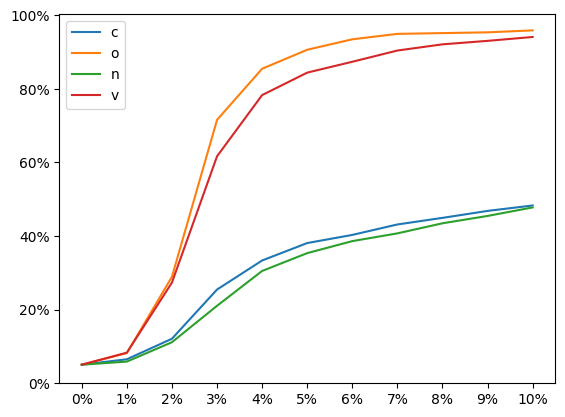

In [21]:
ctiny_versions_display = ["ConvNeXt-T", "No Layerscale", "Batchnorm instead of Layernorm", "No Stochastic Depth"]
for i,entry in enumerate(accuracies):
    plt.plot(entry)
plt.legend(ctiny_versions_display,loc=2)
plt.yticks([0,0.2,0.4,0.6,0.8,1.0],[str(x) + "%" for x in range(0,101,20)])
plt.xticks([x for x in range(11)],[str(x) + "%" for x in range(11)])


In [42]:
print(accuracies)

[]


In [17]:
print(xai_methods)

['gradcam', 'ig_fixpoints', 'lime', 'prism', 'xrai']


In [35]:
performance_xai_resnet = pickle.load(open(DATASET_PATH + "resnet50" + "adv_results.pkl", 'rb'))
performance_xai_convnext_tiny = pickle.load(open(DATASET_PATH + "convnext_tiny" + "adv_results.pkl", 'rb'))
performance_xai_simple_cnn = pickle.load(open(DATASET_PATH + "simple_cnn" + "adv_results.pkl", 'rb'))
performance_xai_vgg16 = pickle.load(open(DATASET_PATH + "vgg16" + "adv_results.pkl", 'rb'))
perf_tables = [performance_xai_simple_cnn,performance_xai_vgg16,performance_xai_resnet,performance_xai_convnext_tiny]

In [26]:
accuracies_all = []
for performance_xai_type in perf_tables:
    accuracies = []
    for current_method in xai_methods:
        print(current_method)
        correct,correct_5,softmax,score,loss = performance_xai_type[current_method]
        accuracy = np.mean((np.divide(correct,50)),axis=1)
        accuracies.append(accuracy)
    accuracies_all.append(accuracies)

gradcam
ig_fixpoints
lime
prism
xrai
gradcam
ig_fixpoints
lime
prism
xrai
gradcam
ig_fixpoints
lime
prism
xrai
gradcam
ig_fixpoints
lime
prism
xrai


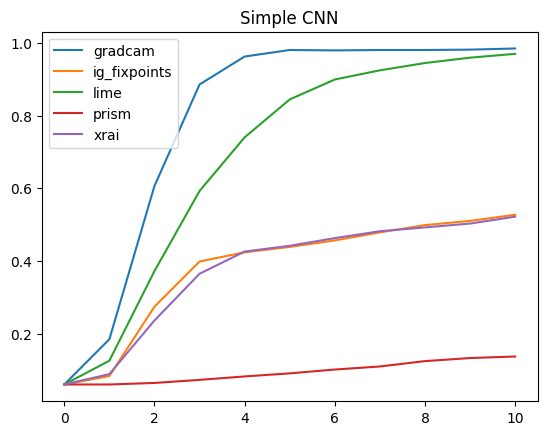

[array([0.06105263, 0.18526316, 0.60631579, 0.88526316, 0.96210526,
       0.98      , 0.97894737, 0.98      , 0.98      , 0.98105263,
       0.98421053]), array([0.06105263, 0.08421053, 0.27473684, 0.39894737, 0.42421053,
       0.43894737, 0.45684211, 0.47894737, 0.49894737, 0.51052632,
       0.52736842]), array([0.06105263, 0.12631579, 0.37263158, 0.59263158, 0.74      ,
       0.84421053, 0.89894737, 0.92421053, 0.94421053, 0.95894737,
       0.96947368]), array([0.06105263, 0.06105263, 0.06526316, 0.07368421, 0.08315789,
       0.09157895, 0.10210526, 0.11052632, 0.12526316, 0.13368421,
       0.13789474]), array([0.06105263, 0.08947368, 0.23684211, 0.36526316, 0.42631579,
       0.44210526, 0.46315789, 0.48210526, 0.49263158, 0.50315789,
       0.52210526])]


In [27]:
for entry in accuracies_all[0]:
    plt.plot(entry)
plt.legend(xai_methods)
plt.title('Simple CNN')
plt.show()
print(accuracies_all[0])

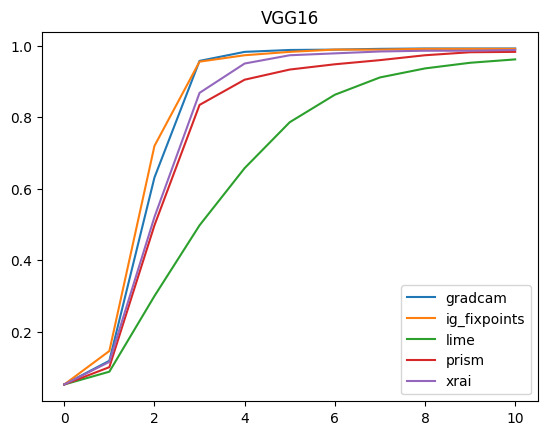

[array([0.05263158, 0.11894737, 0.63157895, 0.95789474, 0.98315789,
       0.98842105, 0.98947368, 0.99157895, 0.99263158, 0.99263158,
       0.99263158]), array([0.05263158, 0.14631579, 0.72      , 0.95578947, 0.97368421,
       0.98315789, 0.98947368, 0.98947368, 0.99157895, 0.99157895,
       0.99157895]), array([0.05263158, 0.08842105, 0.3       , 0.49789474, 0.65789474,
       0.78631579, 0.86315789, 0.91157895, 0.93684211, 0.95263158,
       0.96210526]), array([0.05263158, 0.10105263, 0.49789474, 0.83473684, 0.90526316,
       0.93368421, 0.94842105, 0.96      , 0.97368421, 0.98210526,
       0.98315789]), array([0.05263158, 0.11578947, 0.52105263, 0.86842105, 0.95052632,
       0.97368421, 0.97894737, 0.98421053, 0.98631579, 0.98631579,
       0.98842105])]


In [28]:
for entry in accuracies_all[1]:
    plt.plot(entry)
plt.legend(xai_methods)
plt.title('VGG16')
plt.show()
print(accuracies_all[1])

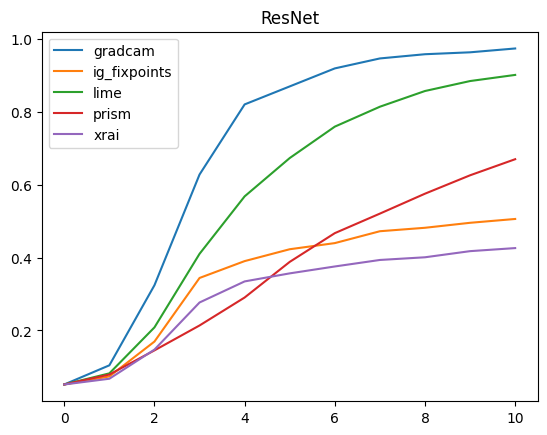

In [29]:
for entry in accuracies_all[2]:
    plt.plot(entry)
plt.legend(xai_methods)
plt.title('ResNet')
plt.show()

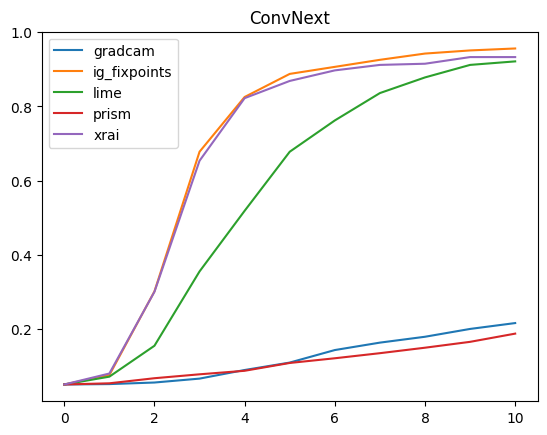

In [30]:
for entry in accuracies_all[3]:
    plt.plot(entry)
plt.legend(xai_methods)
plt.title('ConvNext')
plt.show()

In [31]:
print([x for x in accuracies_all[3]])

[array([0.05157895, 0.05263158, 0.05684211, 0.06736842, 0.09052632,
       0.11052632, 0.14421053, 0.16421053, 0.18      , 0.20105263,
       0.21684211]), array([0.05157895, 0.07684211, 0.30210526, 0.67789474, 0.82526316,
       0.88736842, 0.90631579, 0.92526316, 0.94210526, 0.95052632,
       0.95578947]), array([0.05157895, 0.07263158, 0.15578947, 0.35578947, 0.51894737,
       0.67789474, 0.76210526, 0.83578947, 0.87789474, 0.91157895,
       0.92105263]), array([0.05157895, 0.05473684, 0.06842105, 0.07894737, 0.08842105,
       0.10947368, 0.12210526, 0.13578947, 0.15052632, 0.16631579,
       0.18842105]), array([0.05157895, 0.08105263, 0.30105263, 0.65368421, 0.82210526,
       0.86842105, 0.89684211, 0.91157895, 0.91473684, 0.93263158,
       0.93263158])]


In [36]:
correct,correct_5,softmax,score,loss = performance_xai_convnext_tiny


In [121]:
prism_acc = np.divide(performance_xai_convnext_tiny["prism"][0],50)
gradcam_acc = np.divide(performance_xai_convnext_tiny["gradcam"][0],50)

Text(0.5, 1.0, 'ConvNeXt - GradCAM - Classwise Accuracies')

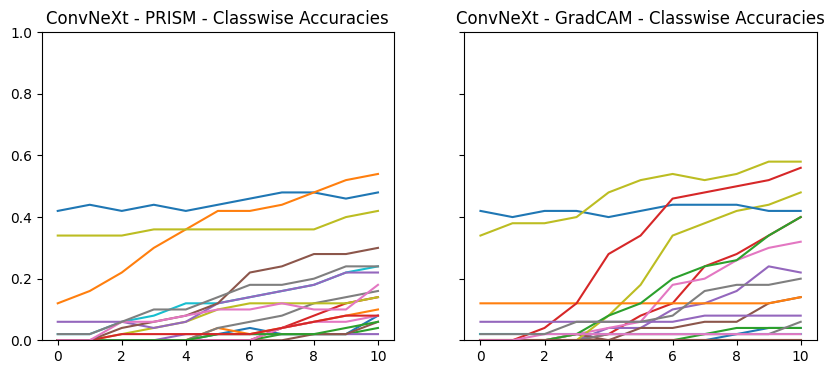

In [135]:
fig, ax = plt.subplots(1,2,figsize=(10,4),sharey=True)
for index,i in enumerate(prism_acc.T):
    ax[0].plot(i)
for index,i in enumerate(gradcam_acc.T):
    ax[1].plot(i)
    
ax[0].set_ylim(ymin=0,ymax=1)

ax[0].set_title("ConvNeXt - PRISM - Classwise Accuracies")
ax[1].set_title("ConvNeXt - GradCAM - Classwise Accuracies")

In [80]:
from PIL import Image
im1 = Image.open("data/auswertung/resnet50/ig_fixpoints/test/00011/mask_on_image/000466.png")
im2 = Image.open("data/auswertung/resnet50/xrai/test/00010/mask_on_image/000444.png")

Text(0.5, 1.0, 'ResNet - IGF')

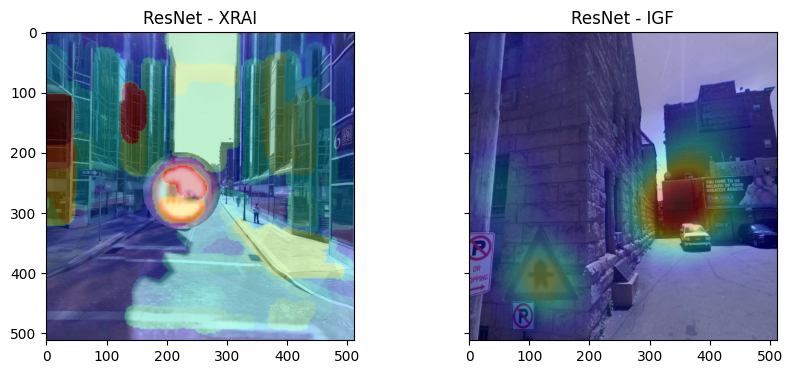

In [84]:
fig, ax = plt.subplots(1,2,figsize=(10,4),sharey=True)
for index,i in enumerate(xrai_acc.T):
    ax[0].imshow(im2)
for index,i in enumerate(igf_acc.T):
    ax[1].imshow(im1)
ax[0].set_title("ResNet - XRAI")
ax[1].set_title("ResNet - IGF")

In [114]:
im1 = np.load("data/auswertung/convnext_tiny/prism/test/00005/mask/000229.png.npy")
im2 = np.load("data/auswertung/convnext_tiny/gradcam/test/00012/grad_mask/000519.png.npy")
im1_raw = Image.open("data/atsds_large/test/00005/000229.png")
im2_raw = Image.open("data/atsds_large/test/00012/000519.png")

Text(0.5, 1.0, 'ConvNeXt - GradCAM')

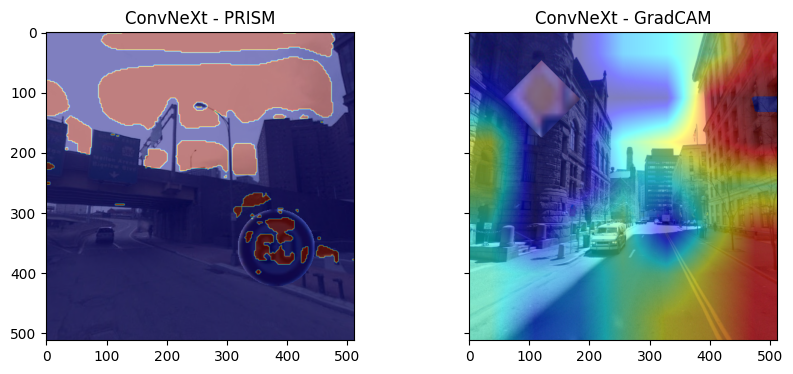

In [115]:
fig, ax = plt.subplots(1,2,figsize=(10,4),sharey=True)
for index,i in enumerate(xrai_acc.T):
    ax[0].imshow(mask_on_image(im1,normalize_image(np.array(im1_raw))))
for index,i in enumerate(igf_acc.T):
    ax[1].imshow(mask_on_image(im2,normalize_image(np.array(im2_raw))))
ax[0].set_title("ConvNeXt - PRISM")
ax[1].set_title("ConvNeXt - GradCAM")

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pickle
from torchvision import transforms

transform_test = transforms.Compose(
    [transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

import cv2
def mask_on_image(mask,img,alpha=0.5):
    heatmap = get_rgb_heatmap(mask)
    img = img
    cam_on_img = (1-alpha)*img + alpha*heatmap
    return np.copy(cam_on_img)

def get_rgb_heatmap(mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255
    return np.copy(heatmap)
def normalize_image(img):
    return np.nan_to_num((img-img.min())/(img.max()-img.min()), nan=0.0, posinf=0.0,neginf=0.0)


In [9]:
with open(DATASET_PATH + "IGF_optimized_parameters.pkl", 'rb') as f:
    optimized_performance = pickle.load(f)
with open(DATASET_PATH + "IGF_initial_parameters.pkl", 'rb') as f:
    initial_performance = pickle.load(f)


In [10]:
print(optimized_performance)

{'simple_cnn': ([array([ 0,  1,  0,  0,  0,  2,  0,  0,  0,  0,  8, 17,  0,  0,  0, 29,  1,
        0,  0], dtype=int64), array([ 1,  2,  0,  0,  1,  6,  2,  0,  0,  2, 15, 24,  0,  0,  2, 31,  2,
        0,  4], dtype=int64), array([ 3,  8, 15,  3, 16, 30, 21,  7, 11,  7, 18, 33,  0,  6, 12, 34, 10,
        9, 18], dtype=int64), array([ 9, 16, 21,  8, 22, 32, 36, 16, 33,  8, 20, 35,  1, 12, 13, 35, 11,
       14, 21], dtype=int64), array([12, 22, 22,  8, 28, 33, 39, 19, 38, 12, 22, 35,  1, 14, 13, 35, 11,
       14, 22], dtype=int64), array([13, 24, 24, 12, 29, 34, 40, 19, 41, 13, 23, 36,  3, 16, 13, 35, 12,
       14, 25], dtype=int64), array([14, 27, 26, 12, 30, 35, 40, 23, 44, 17, 23, 38,  4, 16, 15, 35, 12,
       14, 25], dtype=int64), array([17, 27, 29, 14, 32, 38, 40, 23, 44, 20, 23, 38,  5, 18, 17, 38, 13,
       18, 25], dtype=int64), array([20, 29, 30, 17, 32, 39, 40, 25, 44, 21, 23, 38,  5, 18, 18, 38, 16,
       19, 26], dtype=int64), array([20, 29, 30, 17, 33, 39, 40, 27,

In [11]:
print(initial_performance)

{'simple_cnn': ([array([ 0,  1,  0,  0,  0,  2,  0,  0,  0,  0,  8, 16,  0,  0,  0, 30,  1,
        0,  0], dtype=int64), array([ 0,  2,  0,  0,  0,  4,  1,  0,  0,  1, 12, 22,  0,  0,  1, 31,  1,
        0,  5], dtype=int64), array([ 4,  8, 15,  3, 15, 30, 21,  7, 11,  6, 17, 29,  2,  9, 11, 35,  9,
       10, 19], dtype=int64), array([11, 15, 21,  9, 24, 34, 37, 18, 38,  9, 17, 34,  2, 14, 13, 35, 12,
       14, 22], dtype=int64), array([13, 20, 22, 10, 27, 33, 40, 19, 41, 10, 18, 34,  3, 15, 14, 35, 12,
       15, 22], dtype=int64), array([12, 22, 22, 11, 29, 36, 38, 20, 41, 12, 18, 35,  3, 17, 14, 35, 12,
       17, 23], dtype=int64), array([12, 24, 23, 13, 32, 35, 39, 23, 41, 12, 19, 36,  3, 17, 15, 36, 12,
       17, 25], dtype=int64), array([14, 26, 25, 13, 32, 38, 41, 24, 44, 13, 20, 37,  4, 18, 15, 36, 12,
       18, 25], dtype=int64), array([17, 26, 27, 15, 34, 38, 41, 24, 44, 14, 24, 38,  4, 20, 16, 37, 12,
       18, 25], dtype=int64), array([19, 28, 27, 15, 34, 38, 41, 24,

In [12]:
accuracies_init = []
accuracies_optim = []
for current_method in model_names:
    correct,correct_5,softmax,score,loss = initial_performance[current_method]
    accuracy = np.mean((np.divide(correct,50)),axis=1)
    accuracies_init.append(accuracy)
    correct,correct_5,softmax,score,loss = optimized_performance[current_method]
    accuracy = np.mean((np.divide(correct,50)),axis=1)
    accuracies_optim.append(accuracy)

In [13]:
print(accuracies_init)
print(accuracies_optim)

[array([0.06105263, 0.08421053, 0.27473684, 0.39894737, 0.42421053,
       0.43894737, 0.45684211, 0.47894737, 0.49894737, 0.51052632,
       0.52736842]), array([0.05263158, 0.14631579, 0.72      , 0.95578947, 0.97368421,
       0.98315789, 0.98947368, 0.98947368, 0.99157895, 0.99157895,
       0.99157895]), array([0.05157895, 0.07368421, 0.16947368, 0.34421053, 0.39052632,
       0.42315789, 0.44      , 0.47263158, 0.48210526, 0.49578947,
       0.50631579]), array([0.05157895, 0.07684211, 0.30210526, 0.67789474, 0.82526316,
       0.88736842, 0.90631579, 0.92526316, 0.94210526, 0.95052632,
       0.95578947])]
[array([0.06105263, 0.09684211, 0.27473684, 0.38210526, 0.42105263,
       0.44842105, 0.47368421, 0.50421053, 0.52421053, 0.54315789,
       0.56631579]), array([0.05263158, 0.16315789, 0.69157895, 0.93263158, 0.96      ,
       0.97789474, 0.98315789, 0.98631579, 0.98736842, 0.98736842,
       0.99052632]), array([0.05263158, 0.07157895, 0.15368421, 0.29684211, 0.36736842,
 

In [21]:
model_names_display = ["Simple CNN","VGG16","ResNet50","ConvNeXt-T"]
fig, axs = plt.subplots(2, 2, figsize=(10, 8),dpi=800,sharey=True)

# Plot each element of the array in a separate subplot
for i, value in enumerate(accuracies_init):
    row = i // 2
    col = i % 2
    axs[row, col].plot(accuracies_init[i])
    axs[row, col].plot(accuracies_optim[i])
    axs[row, col].set_title(model_names_display[i])
    axs[row, col].set_xticks([x for x in range(11)],[str(x) + "%" for x in range(11)])
    axs[row, col].set_yticks([0,0.2,0.4,0.6,0.8,1.0],[str(x) + "%" for x in range(0,101,20)])

plt.tight_layout()
axs[0, 1].legend(["Initial Parameters","Optimized Parameters"])
fig.text(0.5,0.0,"Revealed Percentage", ha = 'center')
fig.text(0.0,0.5,"Test-Accuracy", ha = 'center', rotation='vertical')


Text(0.0, 0.5, 'Test-Accuracy')